### Import

In [1]:
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV


## Lettura delle tabelle e selezione della label per addestrare l'svm

In [2]:
df = pd.read_csv('../tables/R.csv')
df = df.drop(columns=df.columns[0])

target_columns = ['likability', 'rewatch', 'arousal', 'valence', 'familiarity']
predictors = list(set(list(df.columns))-set(target_columns))

data_labels = df[target_columns]
data_features = df[predictors]

In [3]:
data_labels = data_labels["arousal"]

In [4]:
print('Number of features:', data_features.shape[1])
print('Number of examples:', data_features.shape[0])
print('Labels:', np.unique(data_labels.values))

Number of features: 147
Number of examples: 1056
Labels: [1 2 3 4 5]


## Divisione tra train e test

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_features.values,
    data_labels.values,
    test_size=0.23,
    random_state=23,
    stratify=data_labels)

## Distribuzione etichette e calcolo baseline

In [6]:
train_outcome = pd.crosstab(index=data_labels,  # Make a crosstab
                              columns="count")      # Name the count column

train_outcome

col_0,count
arousal,
1,109
2,170
3,375
4,250
5,152


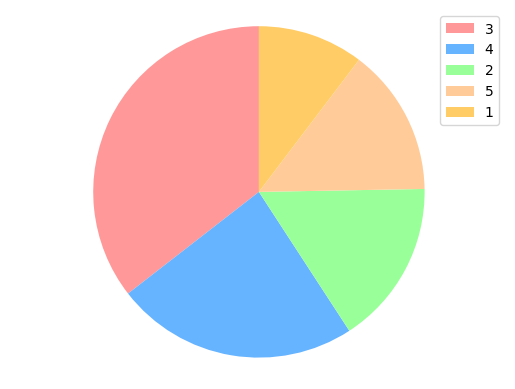

In [7]:
# Visualizing Outcome Distribution 
temp = data_labels.value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

labels = df['labels']
sizes = df['values']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#ffcc66']
patches, texts = plt.pie(sizes, startangle=90, pctdistance=1.1, labeldistance=1.2, colors=colors)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.show()

In [8]:
Baseline = train_outcome.max()[0] / train_outcome.sum()[0]
print('Baseline:', Baseline)

Baseline: 0.35511363636363635


## Train con Grid search e cross validation

In [9]:
# Scaling the Train and Test feature set 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
params_grid = [{    'kernel': ['rbf', 'poly', 'sigmoid'], 
                    'gamma': [1e-2, 1e-3, 1e-4, 1e-5],  
                    'decision_function_shape': ['ovo', 'ovr'], 
                    'C': [1, 10, 100, 1000], 
                    'class_weight': ['balanced', None]
                    }]

In [11]:
# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5, n_jobs=-1)
svm_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': ['balanced', None],
                          'decision_function_shape': ['ovo', 'ovr'],
                          'gamma': [0.01, 0.001, 0.0001, 1e-05],
                          'kernel': ['rbf', 'poly', 'sigmoid']}])

In [12]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_) 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C) 
print('Best Kernel:',svm_model.best_estimator_.kernel)
print('Best Gamma:',svm_model.best_estimator_.gamma)
print('Best Decision_function_shape:',svm_model.best_estimator_.decision_function_shape)
print('Best C:',svm_model.best_estimator_.C)
print('Best class_weight:',svm_model.best_estimator_.class_weight)

final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test_scaled)

Best score for training data: 0.35916837082481257
Best C: 10
Best Kernel: rbf
Best Gamma: 0.0001
Best Decision_function_shape: ovo
Best C: 10
Best class_weight: None


## Risultati

In [13]:
print(confusion_matrix(y_test,Y_pred))
print("\n")
print(classification_report(y_test,Y_pred))  # Support = number of actual occurrences of the class 

print("Training set score for SVM: %f" % final_model.score(X_train_scaled , y_train))
print("Testing  set score for SVM: %f" % final_model.score(X_test_scaled  , y_test))

[[ 0  0 25  0  0]
 [ 0  0 38  0  1]
 [ 0  0 86  0  0]
 [ 0  0 58  0  0]
 [ 0  0 35  0  0]]


              precision    recall  f1-score   support

           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00        39
           3       0.36      1.00      0.52        86
           4       0.00      0.00      0.00        58
           5       0.00      0.00      0.00        35

    accuracy                           0.35       243
   macro avg       0.07      0.20      0.10       243
weighted avg       0.13      0.35      0.19       243

Training set score for SVM: 0.361624
Testing  set score for SVM: 0.353909


c:\Users\Alessio\anaconda3\envs\pytorch-new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Alessio\anaconda3\envs\pytorch-new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Alessio\anaconda3\envs\pytorch-new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)